In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

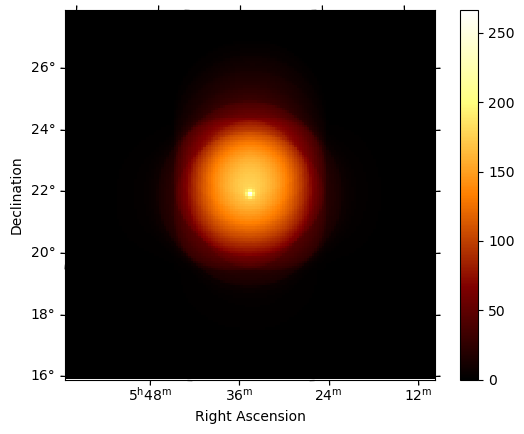

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'

shift = -0.085
tilt = -0.015

In [5]:
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift, 
                        tilt = tilt,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()

zero = 1e-24
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


fit_cor = Fit(store_trace=False)

result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N]) 

In [6]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [7]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

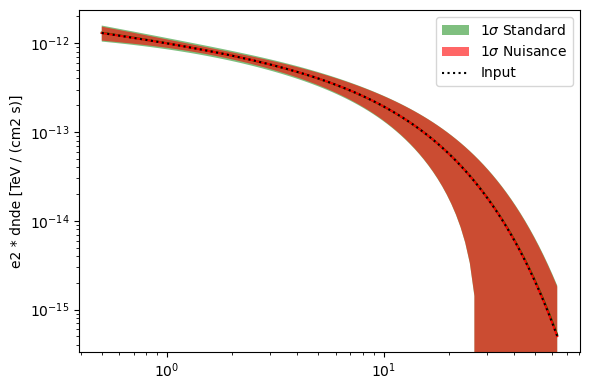

In [8]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (6,4))
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red")    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "red", alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [9]:
compute_fluxpoints = 1
if compute_fluxpoints:
    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_asimov = esti.run([dataset_asimov])
    fluxpoints_asimov.write("data/6_fluxpoints_asimov.fits", overwrite = True)
else:
    fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits")
    

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9976119282813286 1.1085288206208617
norm 0.9981011473757356 0.43376003040035066
norm 0.9984243990536895 0.22560274753747225
norm 0.9988502708638232 0.1988997722135137
norm 0.9993102077895838 0.2059163521723338
norm 0.999832189789069 0.22156952440160607
norm 1.0004392018836257 0.24851291322956137
norm 1.0011761678121942 0.2896806965064845
norm 1.0021101211328494 0.34206535134170035
norm 1.0032582034544186 0.42539636325017594
norm 1.0046464678287523 0.5594094108973229
norm 1.006031304992858 0.7724067584468421
norm 1.0084014266191086 1.1546828626814736
norm 1.0102618425120107 1.8999800579249044
norm 1.0136799087896158 3.4443933517925616
norm 1.017245069226579 7.332532043305936
norm 1.0211828107964454 19.06251523634289
norm 1.0250804335665964 64.33973901463824
norm 1.0 0


In [10]:
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    ## modify the covariance matrix, because only one nuisance parameter here
    #penalising_covmatrix = [[1/sigma_a**2]]
    #penalising_invcovmatrix =  penalising_covmatrix
    #dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
    with dataset_asimov_N.models.restore_status():
        dataset_asimov_N.models.parameters.freeze_all()
        dataset_asimov_N.models.parameters['norm_nuisance'].frozen = False
        dataset_asimov_N.models.parameters['tilt_nuisance'].frozen = False
        fluxpoints_asimov_N = esti_N.run(dataset_asimov_N)

    fluxpoints_asimov_N.write("data/6_fluxpoints_asimov_N.fits", overwrite = True)
else:
    fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits",)

norm 1.0 0
norm_nuisance -0.00024120157480023293 0.0893172477560676
tilt_nuisance 3.6603950795038095e-05 0.014977869182601262
bias 0.0 0.0
resolution 0.0 0.0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 24 is different from 1)

In [ ]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (6,4))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_asimov."+ picformat)
